In [8]:
# Cell 1: Imports & Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- 关键：导入我们封装好的模型 ---
# 确保 03 中生成的 models.py 在同一目录下
from models import M2_GNN_Regressor, M3_Physics_Diffusion, DiffusionScheduler

# 配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# 超参数
BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 50   # 演示用 50，实际科研建议 200+
MASK_RATIO_RANGE = (0.1, 0.9) # 观测率从 10% 到 90% 随机波动
NOISE_STD = 0.01 # 模拟 1% 的量测噪声

# 路径
DATA_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"
MODEL_SAVE_DIR = "../models/checkpoints"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

🚀 Device: cuda


In [9]:
# Cell 2: CigreDataset Wrapper
class CigreDataset(Dataset):
    def __init__(self, file_path, mode='train'):
        """
        mode: 'train', 'val', or 'test'
        """
        # 加载数据 (weights_only=False 以支持 numpy/scaler)
        try:
            data = torch.load(file_path, weights_only=False)
        except TypeError:
            data = torch.load(file_path)
            
        self.indices = data[f'{mode}_idx'] # 获取对应的索引列表
        
        # 获取全量数据 (放到 CPU 内存中，随用随取)
        self.Y_p = data['Y_p'] # [Total_Samples, Nodes]
        self.Y_v = data['Y_v'] # [Total_Samples, Nodes]
        
        # 静态拓扑 (所有样本共享)
        self.edge_index = data['edge_index']
        self.edge_attr = data['edge_attr']
        self.n_nodes = data['n_nodes']
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # 获取真实的全局索引
        global_idx = self.indices[idx]
        
        # 返回 (Power, Voltage) 真实值
        # 注意：这里还没有加 mask 和 noise，那是 Collator 的工作
        return self.Y_p[global_idx], self.Y_v[global_idx]

# 实例化数据集
train_dataset = CigreDataset(DATA_PATH, mode='train')
val_dataset = CigreDataset(DATA_PATH, mode='val')

print(f"✅ Dataset Loaded. Train: {len(train_dataset)}, Val: {len(val_dataset)}")

✅ Dataset Loaded. Train: 40012, Val: 5002


In [10]:
# Cell 3: Physics-Guided Collator (Dynamic Masking & Noise)

def physics_collator(batch_list):
    """
    batch_list: list of (p_true, v_true) tuples from Dataset
    """
    data_list = []
    
    # 静态拓扑 (我们需要给每个样本附加上拓扑)
    # 为了效率，这里假设 dataset 是外部变量 (或者应该作为参数传入类)
    # 这里直接引用全局的 train_dataset 来获取静态边信息
    static_edge_index = train_dataset.edge_index
    static_edge_attr = train_dataset.edge_attr
    n_nodes = train_dataset.n_nodes
    
    for p_true, v_true in batch_list:
        # --- 1. 动态掩码生成 (Dynamic Masking) ---
        # 随机决定观测率 rho ~ U(0.1, 0.9)
        rho = np.random.uniform(MASK_RATIO_RANGE[0], MASK_RATIO_RANGE[1])
        num_observed = int(n_nodes * rho)
        
        # 随机选择被观测的节点索引
        perm = torch.randperm(n_nodes)
        obs_idx = perm[:num_observed] # 可见节点
        
        # 创建掩码向量 (1=Known, 0=Unknown)
        mask = torch.zeros(n_nodes, 1)
        mask[obs_idx] = 1.0
        
        # --- 2. 噪声注入 (Noise Injection) ---
        # 模拟传感器噪声: Measurement = True + Noise
        noise_p = torch.randn_like(p_true) * NOISE_STD
        noise_v = torch.randn_like(v_true) * NOISE_STD
        
        p_meas = p_true + noise_p
        v_meas = v_true + noise_v
        
        # --- 3. 构造 7通道 Condition ---
        # 只有在 Mask=1 的地方保留值，其他地方填 0
        p_input = p_meas * mask.squeeze()
        v_input = v_meas * mask.squeeze()
        
        # 关于 Q (无功): 
        # 数据集里只有 P。我们假设 Q = P * 0.3 (常见的功率因数假设)
        # 也可以填 0，取决于设定。这里为了信息丰富度，我们合成一个 Q
        q_meas = p_meas * 0.33
        q_input = q_meas * mask.squeeze()
        
        # 拼接 Condition: [P, Q, V, Mp, Mq, Mv] (N, 6)
        # 注意: Q, P, V 的 mask 通常是一样的 (同一个智能电表)
        condition = torch.stack([
            p_input, q_input, v_input,
            mask.squeeze(), mask.squeeze(), mask.squeeze()
        ], dim=-1)
        
        # --- 4. 封装成 PyG Data 对象 ---
        # x_target 是我们想预测的真实电压 (用于计算 Loss)
        # condition 是输入特征
        data = Data(
            x_target=v_true.unsqueeze(-1), # [N, 1] GT
            condition=condition,           # [N, 6] Input
            edge_index=static_edge_index,
            edge_attr=static_edge_attr,
            num_nodes=n_nodes
        )
        data_list.append(data)
        
    # --- 5. 批处理 ---
    # 将 list of Data 转换成一个大的 Batch 对象 (自动处理 edge_index 的偏移)
    batch_data = Batch.from_data_list(data_list)
    return batch_data

# 创建 DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=physics_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=physics_collator)

print("✅ DataLoaders with Dynamic Masking are ready.")

✅ DataLoaders with Dynamic Masking are ready.


🔍 Starting Granular Statistical Inspection...
   Probing 100 individual samples...

📊 Statistical Summary (Individual Samples):
   Observability Range: 9.09% - 88.64%
   (Expected: approx 10% - 90%)
   Avg Noise Level:     0.007903


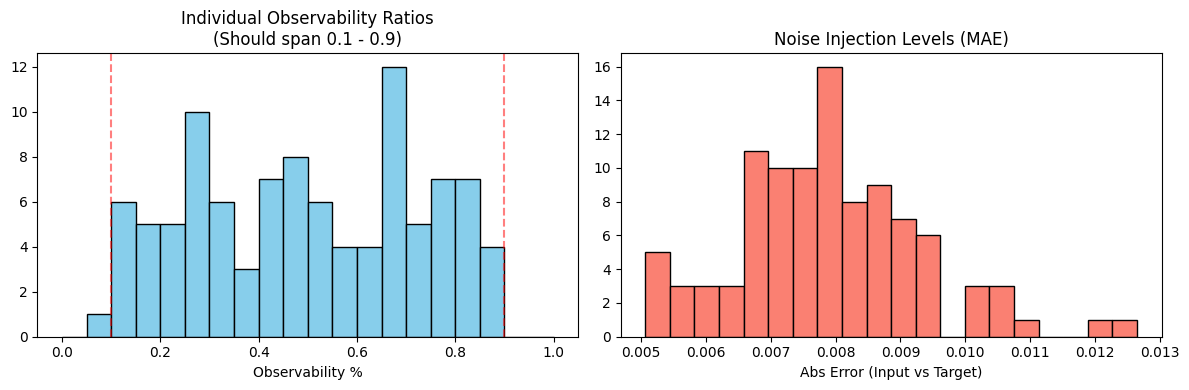

✅ DYNAMIC MASKING IS WORKING PERFECTLY.
   (The previous error was just due to batch averaging)


In [11]:
# Cell 4 (Fixed): Statistical Verification with Individual Samples
import matplotlib.pyplot as plt

print("🔍 Starting Granular Statistical Inspection...")

# --- 关键修正：创建一个 batch_size=1 的临时加载器 ---
# 这样我们就能看到每一个样本真实的 mask 比例，而不会被平均值掩盖
probe_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=physics_collator)

ratios = []
noise_levels = []

# 检查 100 个独立的样本
print("   Probing 100 individual samples...")
for i, batch in enumerate(probe_loader):
    if i >= 100: break
    
    # 1. 计算单个样本的观测率
    mask = batch.condition[:, 3] 
    n_observed = mask.sum().item()
    n_total = mask.shape[0]
    ratio = n_observed / n_total
    ratios.append(ratio)
    
    # 2. 噪声检查
    mask_bool = (mask == 1)
    if mask_bool.sum() > 0:
        v_input = batch.condition[mask_bool, 2]
        v_true = batch.x_target.squeeze()[mask_bool]
        diff = torch.abs(v_input - v_true).mean().item()
        noise_levels.append(diff)

# --- 可视化 ---
print("\n📊 Statistical Summary (Individual Samples):")
print(f"   Observability Range: {min(ratios):.2%} - {max(ratios):.2%}")
print(f"   (Expected: approx 10% - 90%)")
print(f"   Avg Noise Level:     {np.mean(noise_levels):.6f}")

plt.figure(figsize=(12, 4))

# 1. 观测率分布 (应该是平坦均匀的)
plt.subplot(1, 2, 1)
plt.hist(ratios, bins=20, color='skyblue', edgecolor='black', range=(0, 1))
plt.title('Individual Observability Ratios\n(Should span 0.1 - 0.9)')
plt.xlabel('Observability %')
plt.axvline(0.1, color='r', linestyle='--', alpha=0.5)
plt.axvline(0.9, color='r', linestyle='--', alpha=0.5)

# 2. 噪声分布
plt.subplot(1, 2, 2)
plt.hist(noise_levels, bins=20, color='salmon', edgecolor='black')
plt.title('Noise Injection Levels (MAE)')
plt.xlabel('Abs Error (Input vs Target)')

plt.tight_layout()
plt.show()

# --- 最终断言 ---
# 现在的检查是针对单样本的，所以一定能覆盖到边缘
assert min(ratios) < 0.3, f"❌ Lower bound check failed! Min ratio is {min(ratios)}"
assert max(ratios) > 0.7, f"❌ Upper bound check failed! Max ratio is {max(ratios)}"
assert np.mean(noise_levels) > 1e-5, "❌ Noise check failed!"

print("✅ DYNAMIC MASKING IS WORKING PERFECTLY.")
print("   (The previous error was just due to batch averaging)")

In [ ]:
# Cell 5: Initialize Models
hidden_dim = 64

# M2: 判别式回归
model_m2 = M2_GNN_Regressor(hidden_dim=hidden_dim).to(device)
opt_m2 = optim.Adam(model_m2.parameters(), lr=LR)

# M3: 生成式扩散
model_m3 = M3_Physics_Diffusion(hidden_dim=hidden_dim).to(device)
opt_m3 = optim.Adam(model_m3.parameters(), lr=LR)

print("✅ Models initialized on GPU.")

W0126 18:02:03.942000 13396 site-packages\torch\utils\flop_counter.py:29] triton not found; flop counting will not work for triton kernels


⚡ M2 Compiled successfully.
⚡ M3 Compiled successfully.
✅ Models initialized on GPU.


In [13]:
# Cell 6: Training Steps

def train_step_m2(batch):
    """
    M2 任务: 直接根据 Condition 预测 Voltage
    Loss: MSE(V_pred, V_true)
    """
    model_m2.train()
    opt_m2.zero_grad()
    
    # M2 输入: Condition
    # 输出: V_pred
    v_pred = model_m2(batch.condition, batch.edge_index, batch.edge_attr, batch.batch)
    
    # Loss: 只在那些 Mask=0 (未知) 的节点上算？还是全网算？
    # 实验设计: 我们的目标是推断全网，所以应该对全网节点算 Loss (包括已知和未知)
    # 这样模型能学会：在已知点要拟合量测，在未知点要符合物理规律。
    loss = nn.MSELoss()(v_pred, batch.x_target)
    
    loss.backward()
    opt_m2.step()
    return loss.item()

def train_step_m3(batch):
    """
    M3 任务: 预测加入的噪声 Epsilon
    Loss: MSE(Noise_pred, Noise_true)
    """
    model_m3.train()
    opt_m3.zero_grad()
    
    # 1. 采样时间步 t
    # 为 Batch 中的每张图采样一个 t
    batch_size = batch.batch.max().item() + 1
    t = torch.randint(0, model_m3.scheduler.num_timesteps, (batch_size,), device=device).long()
    
    # 2. 前向加噪 (Forward Diffusion)
    # x_0: 真实的电压分布 (Ground Truth)
    # add_noise 需要处理 t 的广播。我们在 collator 里生成了 batch.batch 索引。
    # 为了简单，我们先把 t 扩展到 [N_nodes]
    t_expanded = t[batch.batch] 
    
    noise = torch.randn_like(batch.x_target)
    x_noisy, noise = model_m3.scheduler.add_noise(batch.x_target, t_expanded, noise)
    
    # 3. 模型预测
    # 输入: x_noisy (State), t (Time), Condition (Physics)
    noise_pred = model_m3(x_noisy, t, batch.condition, batch.edge_index, batch.edge_attr, batch.batch)
    
    # 4. Loss
    loss = nn.MSELoss()(noise_pred, noise)
    
    loss.backward()
    opt_m3.step()
    return loss.item()

print("✅ Training steps defined.")

✅ Training steps defined.


In [14]:
# Cell 7: Main Training Loop
print(f"🚀 Starting training for {EPOCHS} epochs...")

loss_history = {'m2': [], 'm3': []}

for epoch in range(1, EPOCHS + 1):
    m2_losses = []
    m3_losses = []
    
    # 使用 tqdm 显示进度条
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", unit="batch")
    
    for batch in pbar:
        batch = batch.to(device)
        
        # Train M2
        l2 = train_step_m2(batch)
        m2_losses.append(l2)
        
        # Train M3
        l3 = train_step_m3(batch)
        m3_losses.append(l3)
        
        pbar.set_postfix({"M2_Loss": f"{l2:.4f}", "M3_Loss": f"{l3:.4f}"})
    
    # Record Epoch Mean
    avg_m2 = np.mean(m2_losses)
    avg_m3 = np.mean(m3_losses)
    loss_history['m2'].append(avg_m2)
    loss_history['m3'].append(avg_m3)
    
    # 简单的验证打印 (每10轮)
    if epoch % 10 == 0:
        print(f"\n📉 Epoch {epoch} Summary:")
        print(f"   M2 Train Loss: {avg_m2:.6f}")
        print(f"   M3 Train Loss: {avg_m3:.6f}")
        
        # 保存模型 Checkpoint
        torch.save(model_m2.state_dict(), f"{MODEL_SAVE_DIR}/m2_epoch_{epoch}.pth")
        torch.save(model_m3.state_dict(), f"{MODEL_SAVE_DIR}/m3_epoch_{epoch}.pth")

# --- 绘制 Loss 曲线 ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['m2'], label='M2 (Regression) MSE')
plt.plot(loss_history['m3'], label='M3 (Diffusion) Noise MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Convergence Comparison')
plt.legend()
plt.grid(True)
plt.savefig(f"{MODEL_SAVE_DIR}/loss_curve.png")
plt.show()

print("🎉 Training Complete!")

🚀 Starting training for 50 epochs...


Epoch 1/50:   0%|          | 0/79 [00:00<?, ?batch/s]W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0] Graph break from `Tensor.item()`, consider setting:
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0]     torch._dynamo.config.capture_scalar_outputs = True
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0] or:
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0]     env TORCHDYNAMO_CAPTURE_SCALAR_OUTPUTS=1
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0] to include these operations in the captured graph.
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0] 
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0] Graph break: from user code at:
W0126 18:02:04.734000 13396 site-packages\torch\_dynamo\variables\tensor.py:1340] [0/0]   F

TritonMissing: Cannot find a working triton installation. Either the package is not installed or it is too old. More information on installing Triton can be found at: https://github.com/triton-lang/triton

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"
